# 任務: 爬取停車場地址、地段號、坪數、地主、停車費。

##### 1. 安裝套件

In [ ]:
# install google chrome
!wget https://dl.google.com/linux/linux_signing_key.pub
!sudo apt-key add linux_signing_key.pub
!echo 'deb [arch=amd64] http://dl.google.com/linux/chrome/deb/ stable main' >> /etc/apt/sources.list.d/google-chrome.list
!sudo apt-get -y update
!sudo apt-get install -y google-chrome-stable

# install chromedriver
# !apt-get install -y qq unzip
!wget -O -y /tmp/chromedriver.zip http://chromedriver.storage.googleapis.com/`curl -sS chromedriver.storage.googleapis.com/LATEST_RELEASE`/chromedriver_linux64.zip
!unzip -y /tmp/chromedriver.zip chromedriver -d /usr/local/bin/

# install selenium
!pip3 install selenium

# install fonts
!apt-get install -y fonts-noto

### 2. 爬取停車場地址及停車費 (以臺北市為例)
##### *註: 車麻吉上之資訊來源為app後端資料庫，並非網路上公開之資料，一般人沒有權限用程式爬取，故先使用臺北市停車管理工程處網站的臺北市公有路外停車場資料替代。

In [118]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

url = 'https://pma.gov.taipei/News.aspx?n=6833ECE829BE5990&sms=504AB58CAE8A1C62&page=1&PageSize=200'

response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')

cities_districts_html = soup.find_all('td', {'data-title': '行政區'})
addresses_html = soup.find_all('td', {'data-title': '停車場地址'})
fees_html = soup.find_all('td', {'data-title': '費率'})

cities_districts = [c_d.text for c_d in cities_districts_html]
cities = ['臺北市']*len(cities_districts)
districts = [c_d.split('市')[-1] for c_d in cities_districts]

addresses = [address.text for address in addresses_html]
fees = [fee.text for fee in fees_html]

# 轉成dataframe
df = pd.DataFrame({'縣市': cities, '行政區': districts, '地址': addresses, '費率':fees})
df

,縣市,行政區,地址,費率
0,臺北市,大安區,信義路3段134巷及建國南路2段25巷交叉口,計時20元
1,臺北市,內湖區,行善路266、268號地下,小型車：計時30元，機車：計時10元(當日當次最高收費20元，隔日另計)
2,臺北市,信義區,大道路116號地下,小型車：計時30元，機車：計時10元(當日當次最高收費20元，隔日另計)
3,臺北市,信義區,福德街86號地下,小型車：計時30元，機車：計時10元(當日當次最高收費20元，隔日另計)
4,臺北市,內湖區,金湖路46巷底,計時20元
...,...,...,...,...
195,臺北市,中山區,八德路2段158號地下,計時20元
196,臺北市,文山區,辛亥路4段103號地下,(8-18)計時20元，(18-8)計時10元
197,臺北市,信義區,松壽路1號地下,小型車(9-18)計時30元 ，(18-9)計時10元，機車計時10元(當日當次最高收費上限...
198,臺北市,南港區,成福路1號,星期一至五(8-18)計時20元，(18-8)計時30元，假日計時30元\r\n


### 3. 資料處理
##### 由上可見有些地址僅是位置之描述，如兩路交叉口或某某捷運站旁等，因此需要針對進行前處理，為簡化流程先將此類資料刪除

In [120]:
def is_valid(s):
    if '號' not in s:
        return False
    chars = ['~', '(', '、', '至', '站']
    for char in chars:
        if char in s:
            return False
    return True

for idx, row in df.iterrows():
    if not is_valid(df['地址'][idx]):
        df.drop(idx, inplace=True)

df

,縣市,行政區,地址,費率
2,臺北市,信義區,大道路116號地下,小型車：計時30元，機車：計時10元(當日當次最高收費20元，隔日另計)
3,臺北市,信義區,福德街86號地下,小型車：計時30元，機車：計時10元(當日當次最高收費20元，隔日另計)
5,臺北市,大同區,民族西路303巷47號旁,計時20元
21,臺北市,文山區,羅斯福路5段236巷3-3號旁,計次50元
22,臺北市,松山區,健康路309號地下,小型車計時30元。機車只出售月票，不提供臨時停車。
...,...,...,...,...
194,臺北市,松山區,健康路325巷19弄1號地下,(8-22)計時30元，(22-8)計時10元。(電動車差別費另計)
195,臺北市,中山區,八德路2段158號地下,計時20元
196,臺北市,文山區,辛亥路4段103號地下,(8-18)計時20元，(18-8)計時10元
197,臺北市,信義區,松壽路1號地下,小型車(9-18)計時30元 ，(18-9)計時10元，機車計時10元(當日當次最高收費上限...


把「地下」、「旁」等無用資訊刪除

In [121]:
for idx, row in df.iterrows():
    value = df['地址'][idx].split('號')[0]+'號'
    df['地址'][idx] = value
df

,縣市,行政區,地址,費率
2,臺北市,信義區,大道路116號,小型車：計時30元，機車：計時10元(當日當次最高收費20元，隔日另計)
3,臺北市,信義區,福德街86號,小型車：計時30元，機車：計時10元(當日當次最高收費20元，隔日另計)
5,臺北市,大同區,民族西路303巷47號,計時20元
21,臺北市,文山區,羅斯福路5段236巷3-3號,計次50元
22,臺北市,松山區,健康路309號,小型車計時30元。機車只出售月票，不提供臨時停車。
...,...,...,...,...
194,臺北市,松山區,健康路325巷19弄1號,(8-22)計時30元，(22-8)計時10元。(電動車差別費另計)
195,臺北市,中山區,八德路2段158號,計時20元
196,臺北市,文山區,辛亥路4段103號,(8-18)計時20元，(18-8)計時10元
197,臺北市,信義區,松壽路1號,小型車(9-18)計時30元 ，(18-9)計時10元，機車計時10元(當日當次最高收費上限...


把1段、2段改成一段、二段

In [125]:
num2cn = {'1段':'一段', '2段':'二段', '3段':'三段', '4段':'四段', '5段':'五段', '6段':'六段', '7段':'七段', '8段':'八段'}

for idx, row in df.iterrows():
    for key in num2cn:
        df['地址'][idx] = df['地址'][idx].replace(key, num2cn[key])
df

,縣市,行政區,地址,費率
2,臺北市,信義區,大道路116號,小型車：計時30元，機車：計時10元(當日當次最高收費20元，隔日另計)
3,臺北市,信義區,福德街86號,小型車：計時30元，機車：計時10元(當日當次最高收費20元，隔日另計)
5,臺北市,大同區,民族西路303巷47號,計時20元
21,臺北市,文山區,羅斯福路五段236巷3-3號,計次50元
22,臺北市,松山區,健康路309號,小型車計時30元。機車只出售月票，不提供臨時停車。
...,...,...,...,...
194,臺北市,松山區,健康路325巷19弄1號,(8-22)計時30元，(22-8)計時10元。(電動車差別費另計)
195,臺北市,中山區,八德路二段158號,計時20元
196,臺北市,文山區,辛亥路四段103號,(8-18)計時20元，(18-8)計時10元
197,臺北市,信義區,松壽路1號,小型車(9-18)計時30元 ，(18-9)計時10元，機車計時10元(當日當次最高收費上限...


### 4. 查詢地段號
##### 台北市可使用地政雲:
##### 連上地政雲網站

In [31]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import Select
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.by import By

chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--headless')
chrome_options.add_argument('--disable-gpu')
chrome_options.add_argument('--disable-dev-shm-usage')
chrome_options.add_argument("--window-size=1920,1080")

driver = webdriver.Chrome(options=chrome_options)

url = "https://cloud.land.gov.taipei/ImmInfo/InteInfo.aspx"
driver.get(url)

截圖觀看結果

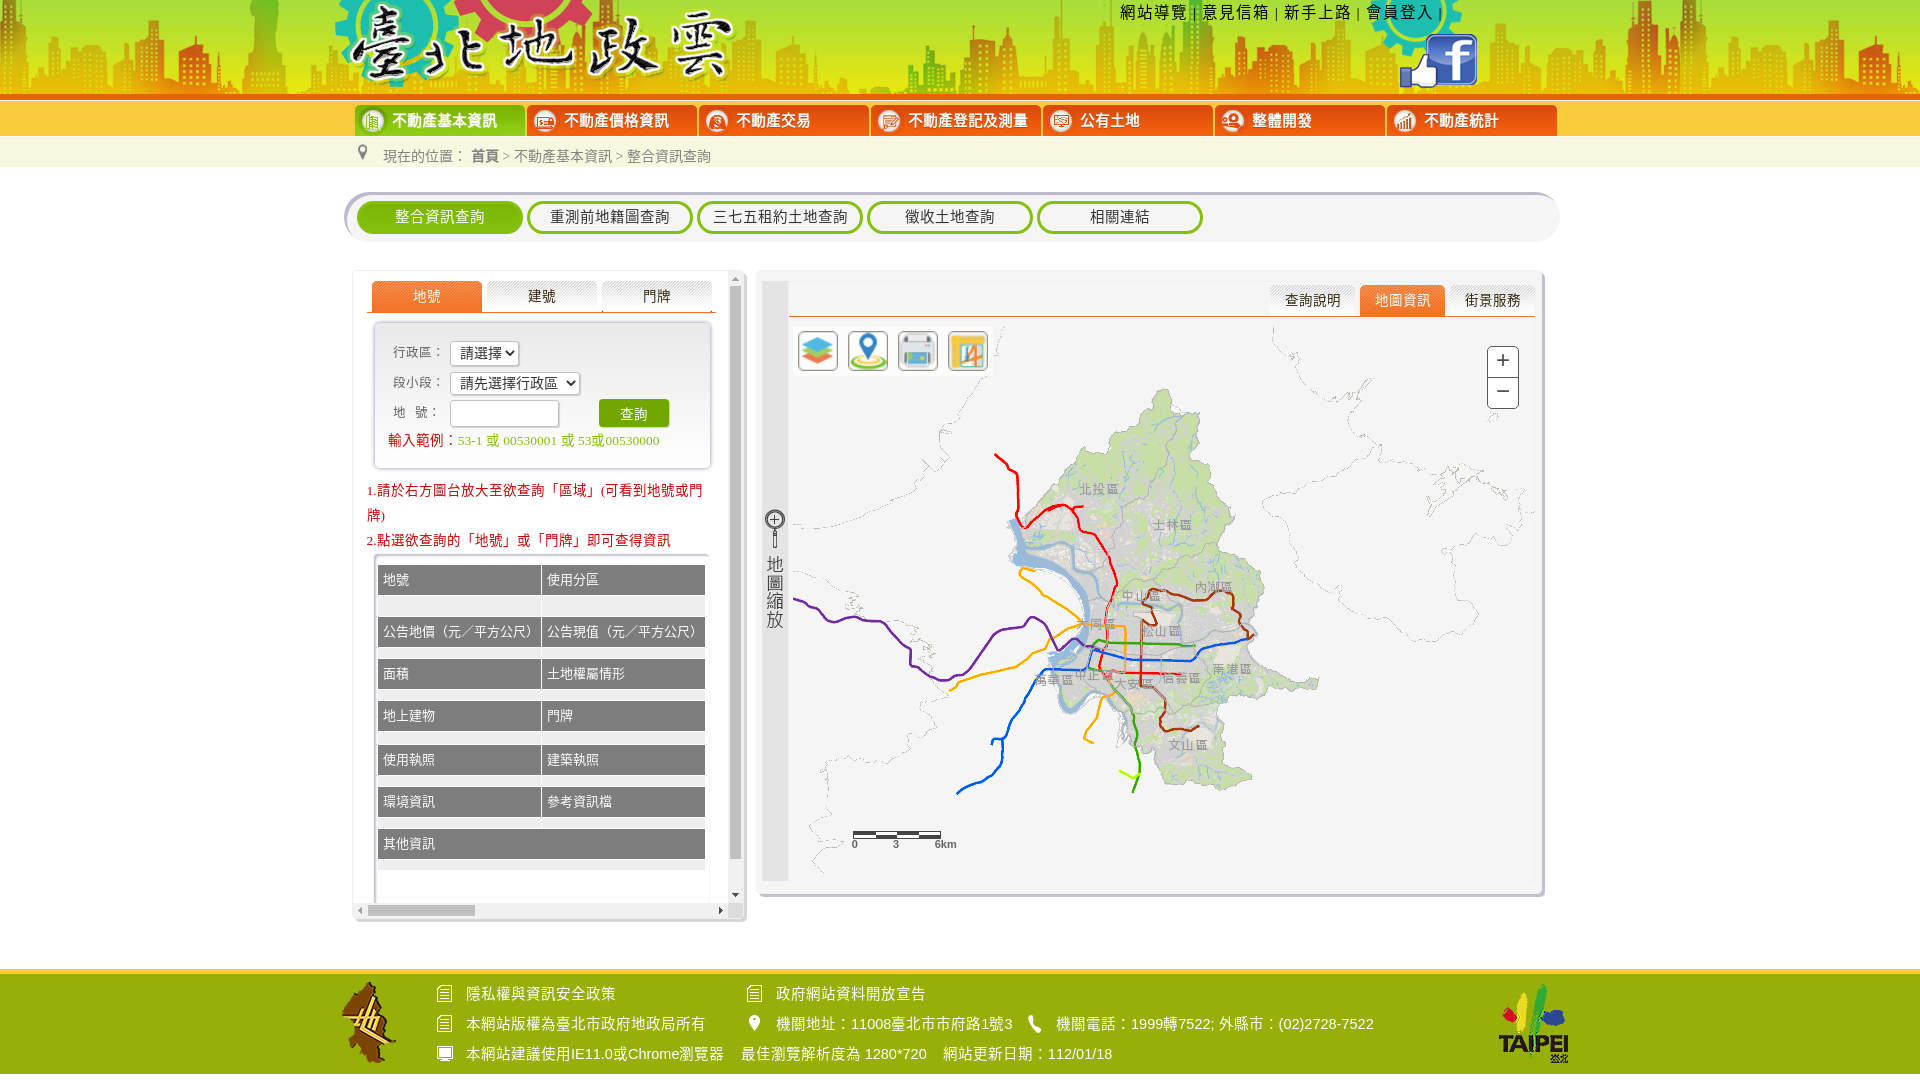

In [33]:
from PIL import Image
driver.save_screenshot('result.png')
img = Image.open('result.png')
img

##### 依照步驟輸入地址

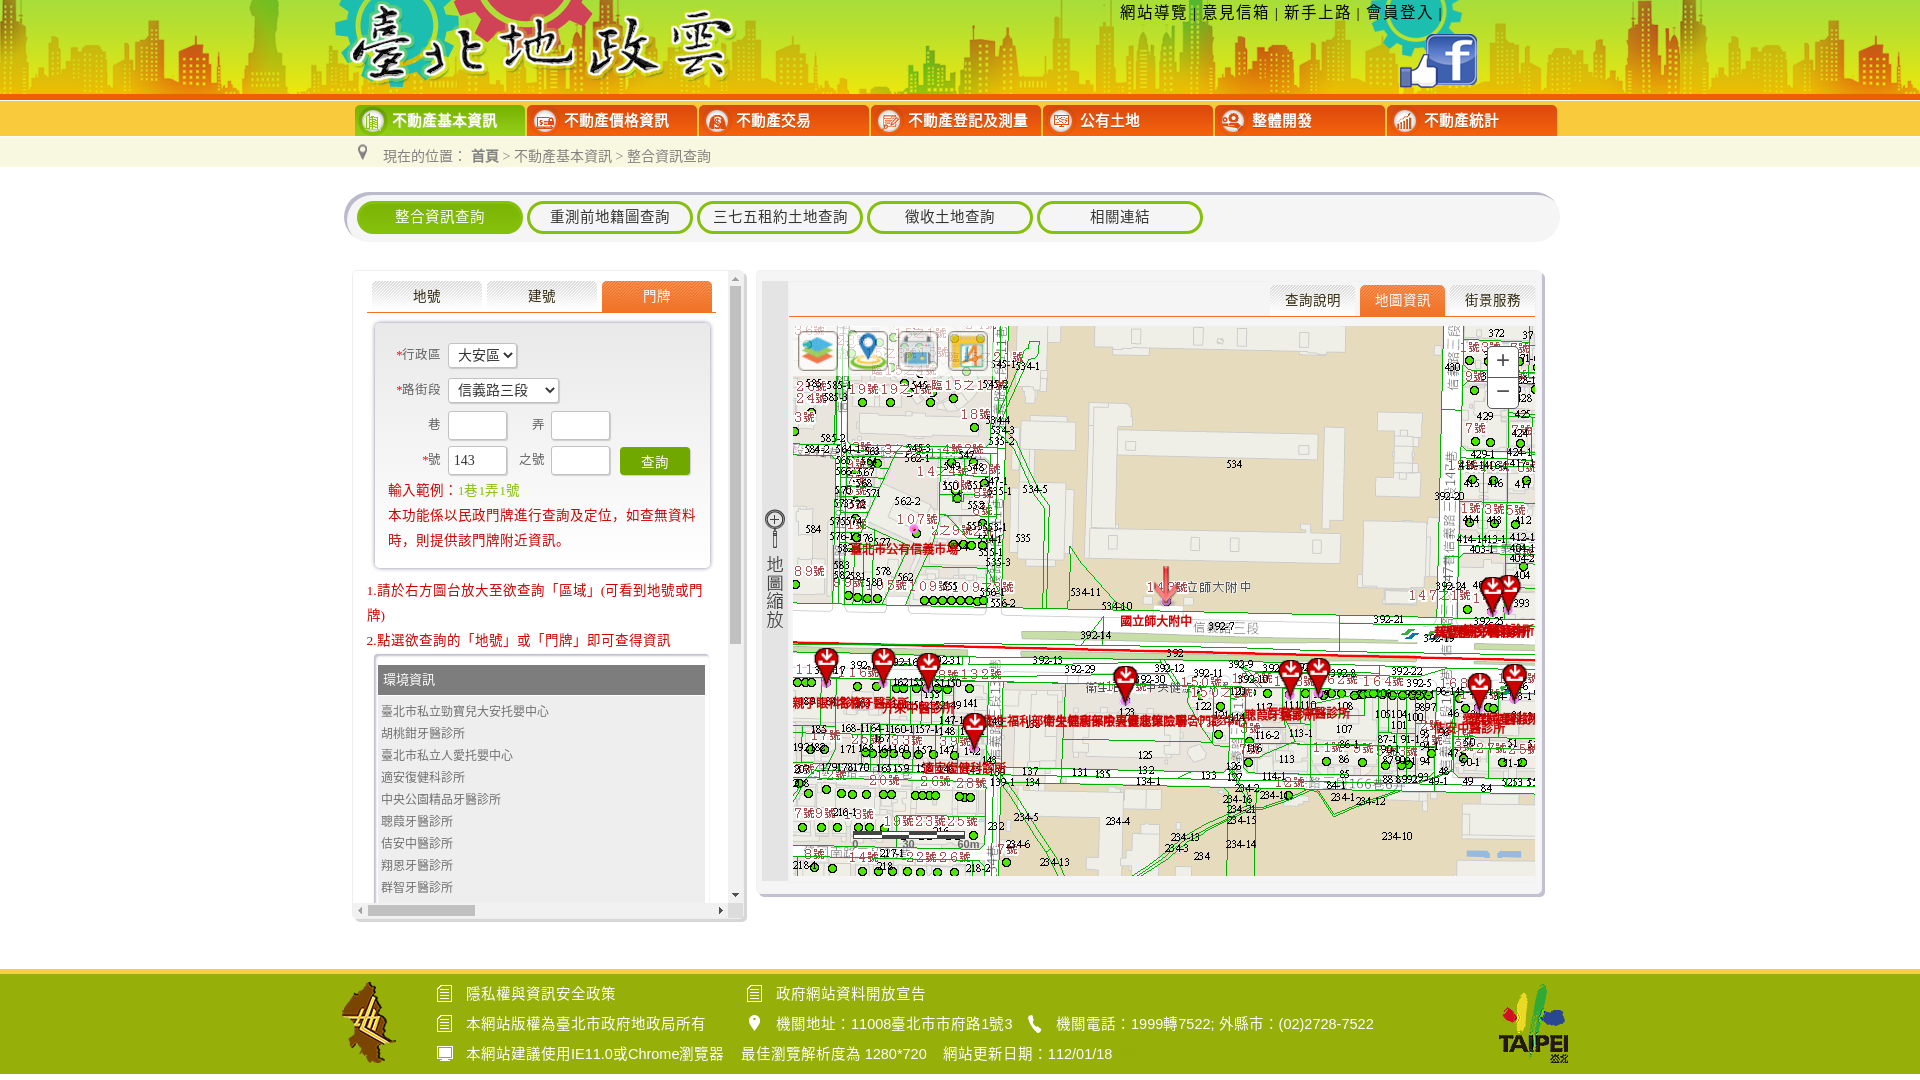

In [34]:
import time
from time import sleep
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

# 1. 點選門牌查詢
driver.find_element(By.XPATH, '//a[@href="#tab3"]').click()

# 2. 選取行政區
sleep(0.1) # 等網頁load好
select = Select(driver.find_element(By.ID, 'ContentPlaceHolder1_ContentPlaceHolder1_DoorNumber_ddl_MasterGond'))
sleep(0.1)
select.select_by_visible_text('大安區')

# 3. 選取路街段
sleep(0.1)
select = Select(driver.find_element(By.ID, 'ContentPlaceHolder1_ContentPlaceHolder1_DoorNumber_ddl_doorNumber'))
sleep(0.1)
select.select_by_visible_text('信義路三段')

# 4. 輸入巷
# sleep(0.1)
# driver.find_element(By.ID, 'ContentPlaceHolder1_ContentPlaceHolder1_DoorNumber_txt_Road1').send_keys('1')

# 5. 輸入號
driver.find_element(By.ID, 'ContentPlaceHolder1_ContentPlaceHolder1_DoorNumber_txt_Road3').send_keys('143')

# 6. 點選查詢
driver.find_element(By.ID, 'ContentPlaceHolder1_ContentPlaceHolder1_DoorNumber_btn_Search').click()
sleep(5)

driver.save_screenshot('result.png')
img = Image.open('result.png')
img

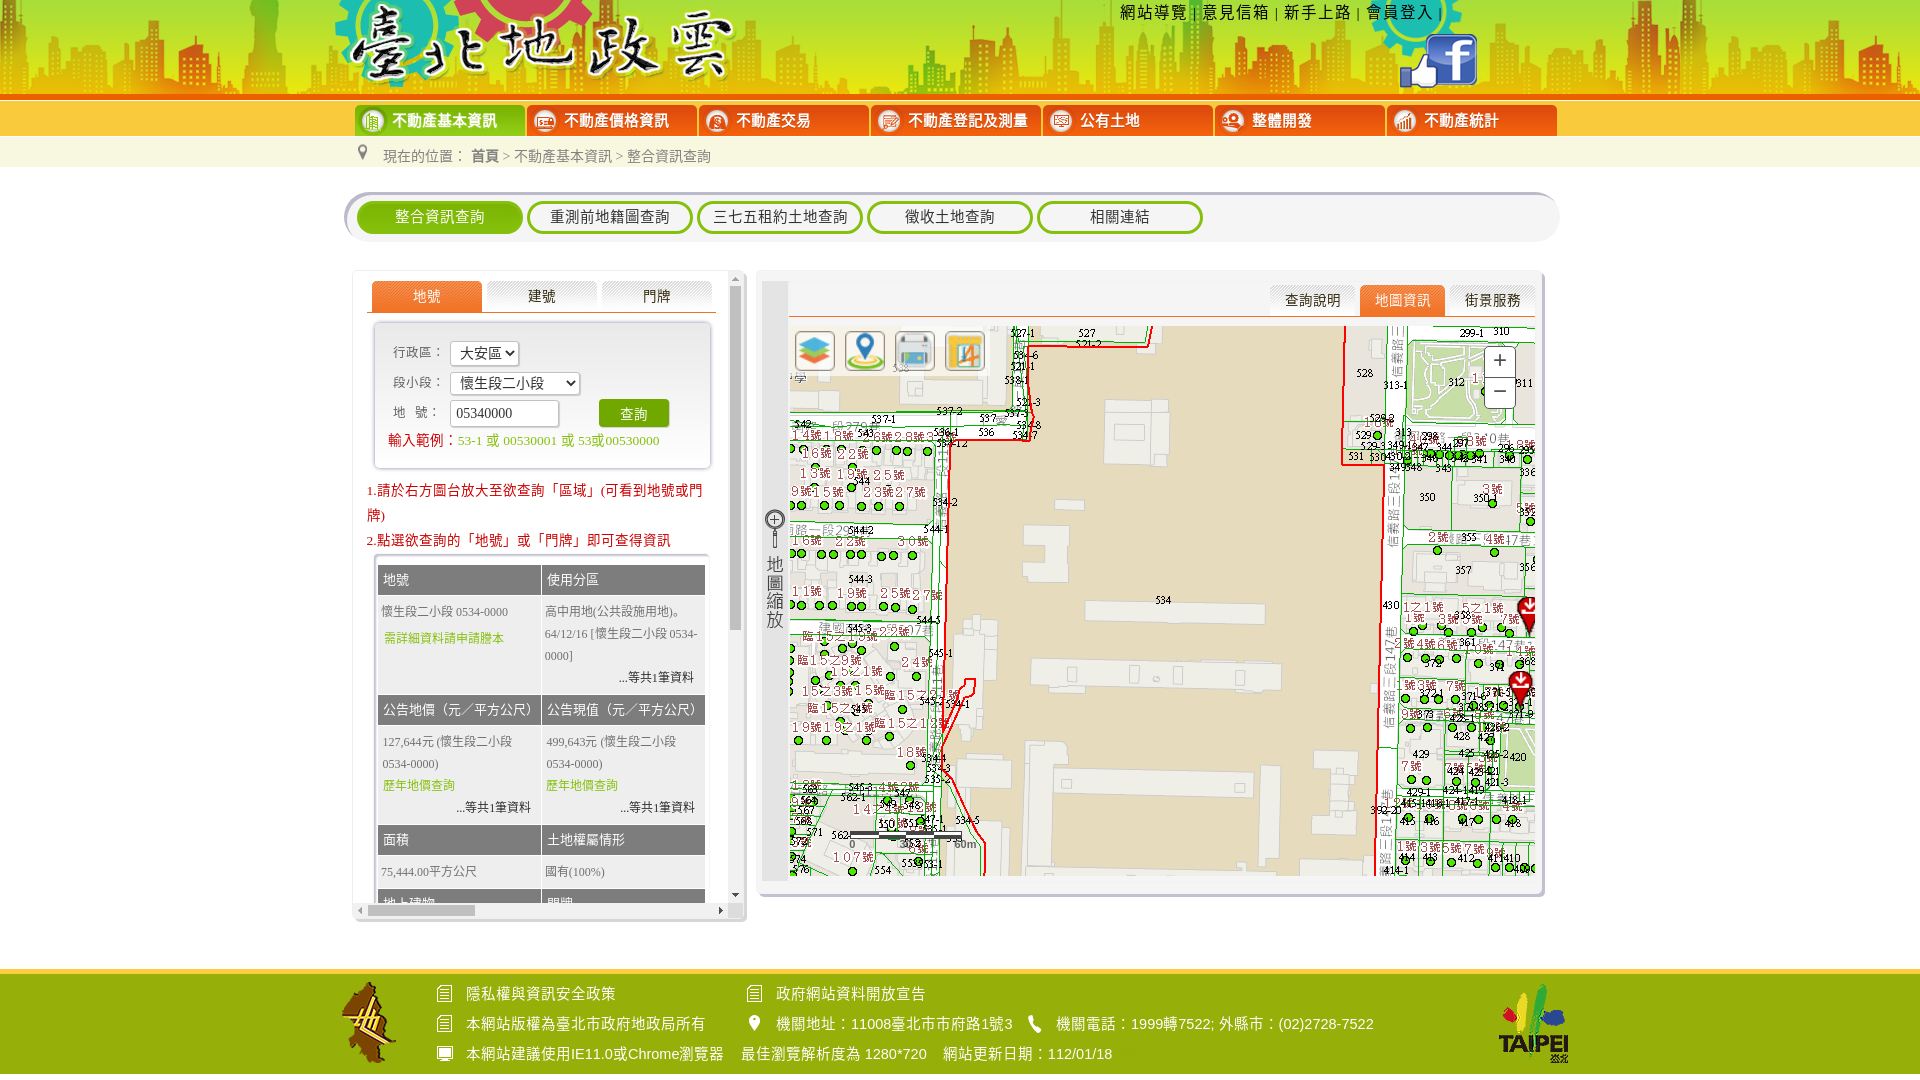

In [35]:
# 6. 點選標的
try:
    # WebDriverWait(driver, 20).until(EC.presence_of_element_located((By.ID, 'BodyRightMain'))).click()
    driver.find_element(By.ID, 'tab5').click()
except Exception as e:
    print(e)

sleep(10)    
driver.save_screenshot('result.png')
img = Image.open('result.png')
img

['懷生段二小段', '05340000', '75,444.00平方公尺']


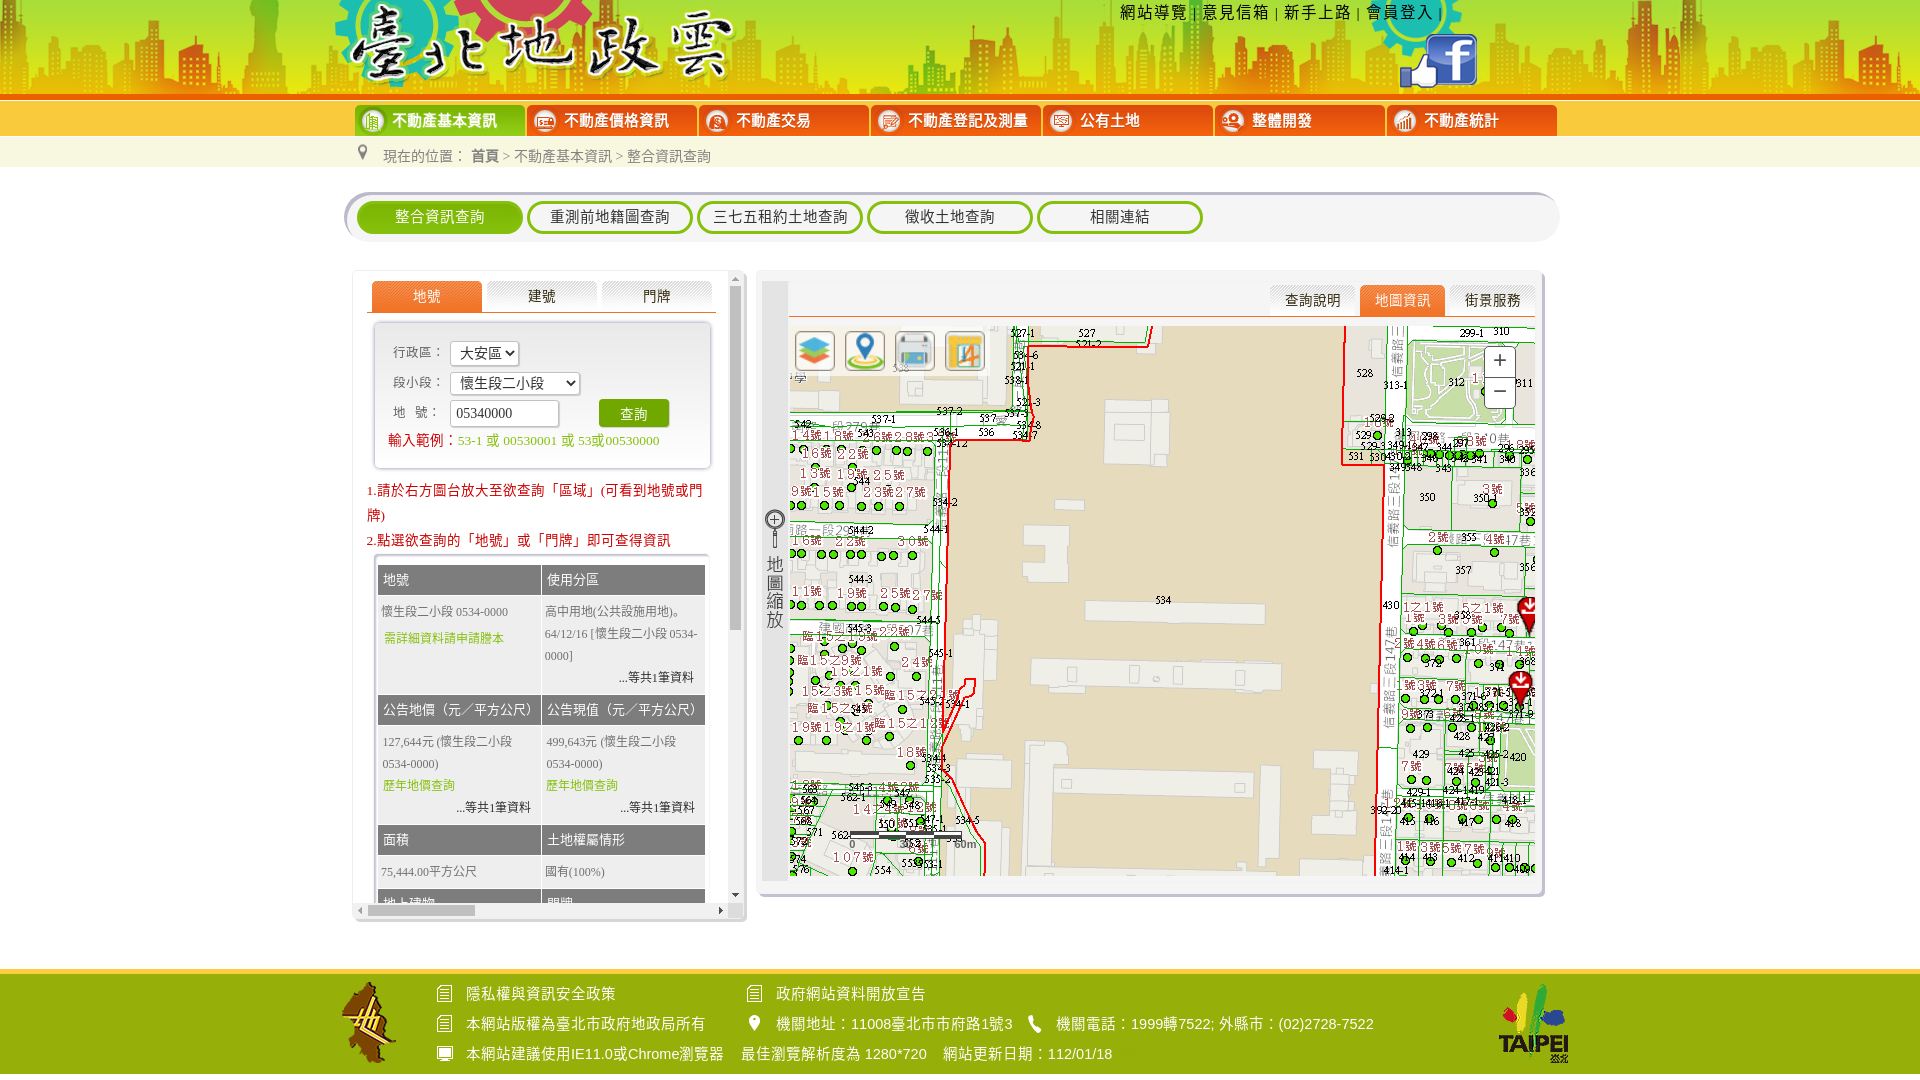

In [36]:
info = []

# 記下地段
select = Select(driver.find_element(By.ID, 'ContentPlaceHolder1_ContentPlaceHolder1_LandNumber_ddl_SubGond'))
selected_option = select.first_selected_option
info.append(selected_option.text)

# 記下地號
land_num = driver.find_element(By.ID, 'ContentPlaceHolder1_ContentPlaceHolder1_LandNumber_txt_LandNumber').get_attribute('value')
info.append(land_num)

# 記下面積
area = driver.find_element(By.ID, 'ContentPlaceHolder1_ContentPlaceHolder1_LandNumber_lbl_Area').text
info.append(area)

print(info)

driver.save_screenshot('result.png')
img = Image.open('result.png')
img

In [37]:
#ids = driver.find_elements(By.XPATH, '//*[@id]')
#for idx, ii in enumerate(ids):
#    #print ii.tag_name
#    print(idx, ii.get_attribute('id')) 